# Определение перспективного тарифа для телеком-компании
## 1. Вводные
### 1.1. Задача
Федеральный оператор сотовой связи предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Есть данные 500 пользователей за 2018 год: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. А также, выяснить, приносят ли клиент из столицы больше выручки, чем клиент из региона.

### 1.2. Гипотезы
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### 1.3. Описание тарифов
#### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

#### Примечание
Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.


### 1.4. Описание данных
#### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

#### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах, нулями обозначены пропущенные звонки.
- user_id — идентификатор пользователя, сделавшего звонок

#### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

#### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## 2. Обзор и предобработка данных

In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'  # переключаем на векторную графику

import warnings
warnings.simplefilter('ignore')  # отключаем предупредения Anaconda

from functools import partialmethod
pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine='python')  # просим query() всегда работать
                                                                         # с параметром engine='python'

In [2]:
# локальные адреса
try:
    calls_df = pd.read_csv('calls.csv')
    internet_df = pd.read_csv('internet.csv')
    messages_df = pd.read_csv('messages.csv')
    tariffs_df = pd.read_csv('tariffs.csv')
    users_df = pd.read_csv('users.csv')
# адреса в тренажоре
except:
    calls_df = pd.read_csv('/datasets/calls.csv')
    internet_df = pd.read_csv('/datasets/internet.csv')
    messages_df = pd.read_csv('/datasets/messages.csv')
    tariffs_df = pd.read_csv('/datasets/tariffs.csv')
    users_df = pd.read_csv('/datasets/users.csv')
    
dfs = [calls_df, internet_df, messages_df, tariffs_df, users_df]

In [3]:
# рассчитывает число пропусков и тип колонок датафрейма
def gaps(df):
    gaps_df = pd.DataFrame(data={'gaps_share': (df.isna().sum() / df.shape[0]).values,
                                 'type': df.dtypes.values},
                           index=df.columns)
    gaps_df.query('gaps_share > 0').sort_values(by='gaps_share', ascending=False)    
    display(gaps_df)

# выводит на экран основную информацию о датафрейме
def look_at(df):
    print(df.shape[0], 'strings')
    print(df.duplicated().sum(), 'duplicated')
    gaps(df)
    try:
        display(df.sample(5))
    except:                  
        display(df)  # не во всех таблицах есть 5 строк
    display(df.describe())     

### 2.1. Звонки
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [4]:
look_at(calls_df)

202607 strings
0 duplicated


,gaps_share,type
id,0.0,object
call_date,0.0,object
duration,0.0,float64
user_id,0.0,int64


,id,call_date,duration,user_id
5804,1017_0,2018-11-20,0.00,1017
93305,1233_650,2018-12-20,8.21,1233
137704,1352_428,2018-12-16,13.64,1352
180759,1452_133,2018-10-08,1.52,1452
25671,1064_280,2018-07-16,0.43,1064


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [5]:
# Столбец с именем id встречается и в других таблицах, переименуем его, чтобы не запутаться
calls_df.rename(columns={'id': 'call_id'}, inplace=True)

# Изменим фотмат даты на datetime
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')

# Продолжительность каждого звонка округляют вверх согласно документации
calls_df['duration'] = np.ceil(calls_df['duration']).astype('int')

# Пропусков и дубликатов нет
# Значения duration выглядят преемлемо

calls_df.info()
calls_df.call_date.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   call_id    202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

Отлично, у нас данные за 2018 год.

### 2.2. Интернет

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [6]:
look_at(internet_df)

149396 strings
0 duplicated


,gaps_share,type
Unnamed: 0,0.0,int64
id,0.0,object
mb_used,0.0,float64
session_date,0.0,object
user_id,0.0,int64


,Unnamed: 0,id,mb_used,session_date,user_id
6407,6407,1021_51,579.76,2018-05-21,1021
126243,126243,1424_104,670.48,2018-12-06,1424
51074,51074,1174_282,0.00,2018-06-06,1174
101079,101079,1339_58,424.73,2018-11-25,1339
47714,47714,1164_283,0.00,2018-06-26,1164


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [7]:
# Столбец с именем id встречается и в других таблицах, переименуем его, чтобы не запутаться
internet_df.rename(columns={'id': 'session_id'}, inplace=True)

# Изменим фотмат даты на datetime
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format='%Y-%m-%d')

# Проверим, совпадает ли лишний столбец с индексами
(internet_df['Unnamed: 0'] != internet_df.index).sum()

0

In [8]:
del internet_df['Unnamed: 0']

# Пропусков и дубликатов нет
# Значения mb_used выглядят преемлемо

internet_df.info()
internet_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


,session_id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


### 2.3. Сообщения

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [9]:
look_at(messages_df)

123036 strings
0 duplicated


,gaps_share,type
id,0.0,object
message_date,0.0,object
user_id,0.0,int64


,id,message_date,user_id
41519,1176_270,2018-02-24,1176
320,1000_320,2018-07-14,1000
71250,1302_78,2018-12-17,1302
75408,1318_437,2018-09-05,1318
23540,1097_55,2018-10-20,1097


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [10]:
# Столбец с именем id встречается и в других таблицах, переименуем его, чтобы не запутаться
messages_df.rename(columns={'id': 'message_id'}, inplace=True)

# Изменим фотмат даты на datetime
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d')

# Пропусков и дубликатов нет

messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   message_id    123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


### 2.4. Тарифы

Повторим информацию о тарифах для удобства.

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

#### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей


In [11]:
look_at(tariffs_df)

2 strings
0 duplicated


,gaps_share,type
messages_included,0.0,int64
mb_per_month_included,0.0,int64
minutes_included,0.0,int64
rub_monthly_fee,0.0,int64
rub_per_gb,0.0,int64
rub_per_message,0.0,int64
rub_per_minute,0.0,int64
tariff_name,0.0,object


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


In [12]:
# видим, что числа делятся без остатка
tariffs_df['mb_per_month_included'] = tariffs_df['mb_per_month_included'] // 1024

In [13]:
tariffs_df.rename(columns={'mb_per_month_included': 'gb_included'}, inplace=True)
tariffs_df.T

,0,1
messages_included,50,1000
gb_included,15,30
minutes_included,500,3000
rub_monthly_fee,550,1950
rub_per_gb,200,150
rub_per_message,3,1
rub_per_minute,3,1
tariff_name,smart,ultra


Тут всё в порядке

### 2.5. Пользователи
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана


In [14]:
look_at(users_df)

500 strings
0 duplicated


,gaps_share,type
user_id,0.000,int64
age,0.000,int64
churn_date,0.924,object
city,0.000,object
first_name,0.000,object
last_name,0.000,object
reg_date,0.000,object
tariff,0.000,object


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
405,1405,54,NaN,Набережные Челны,Элина,Белова,2018-10-08,ultra
448,1448,42,NaN,Кострома,Ростислав,Дроздов,2018-09-16,smart
67,1067,45,NaN,Москва,Юзефа,Абашкина,2018-04-09,smart
412,1412,63,NaN,Волгоград,Геодар,Афонин,2018-06-05,ultra


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [15]:
# Изменим фотмат дат на datetime
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], format='%Y-%m-%d')
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')

# Пропуски есть только в churn_date, но они объяснены в документации — эти люди не отключали тариф
# Дубликатов нет

users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### 2.6. Валидации и поиск аномалий


In [16]:
# проверка уникальности *_id
for df, column in [(users_df, 'user_id'), 
                   (calls_df, 'call_id'),
                   (messages_df, 'message_id'), 
                   (internet_df, 'session_id')]:
    print(df[column].duplicated().sum())

0
0
0
0


In [17]:
# проверка на непустоту и аномалии
for df in dfs:
    for column in df.select_dtypes(['O', 'category']).columns:
        print(column, '\nEmpty strings:', (df[column] == '').sum())
        print(df[column].value_counts().head(3), '\n')

call_id 
Empty strings: 0
1000_0      1
1344_881    1
1344_883    1
Name: call_id, dtype: int64 

session_id 
Empty strings: 0
1000_0      1
1333_109    1
1334_0      1
Name: session_id, dtype: int64 

message_id 
Empty strings: 0
1000_0      1
1344_248    1
1344_96     1
Name: message_id, dtype: int64 

tariff_name 
Empty strings: 0
smart    1
ultra    1
Name: tariff_name, dtype: int64 

city 
Empty strings: 0
Москва             99
Санкт-Петербург    39
Новосибирск        16
Name: city, dtype: int64 

first_name 
Empty strings: 0
Радим     6
Леонид    5
Пётр      5
Name: first_name, dtype: int64 

last_name 
Empty strings: 0
Андреенко    5
Березина     3
Аркадьев     3
Name: last_name, dtype: int64 

tariff 
Empty strings: 0
smart    351
ultra    149
Name: tariff, dtype: int64 



In [18]:
# проверка диапазона дат, предположительно все должны быть в 2018-м
for df in dfs:
    for column in df.select_dtypes(['datetime64[ns]']).columns:
        print(column)
        display(df[column].describe())

call_date


count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

session_date


count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

message_date


count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

churn_date


count                      38
unique                     33
top       2018-12-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: churn_date, dtype: object

reg_date


count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

In [19]:
# проверка, что пользователь на расторгал контракт раньше, чем заключал
(users_df['churn_date'] < users_df['reg_date']).sum()

0

In [20]:
# проверка, что для каждого звонка, сообщения и интернет-сессии у нас есть информация о пользователе
for df in [calls_df, messages_df, internet_df]:
    display(df[~df['user_id'].isin(users_df['user_id'])])

,call_id,call_date,duration,user_id


,message_id,message_date,user_id


,session_id,mb_used,session_date,user_id


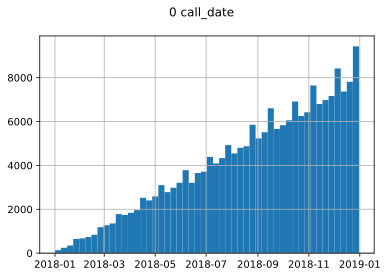

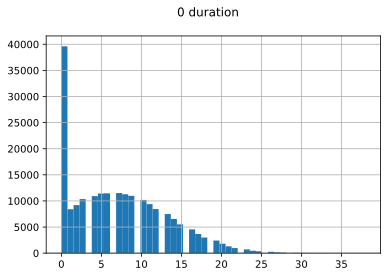

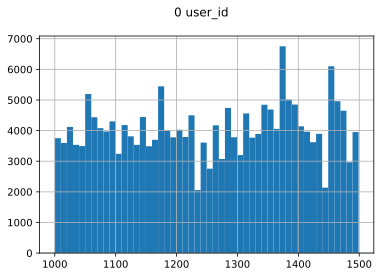

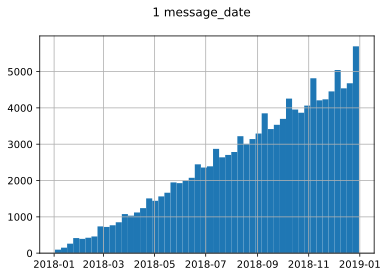

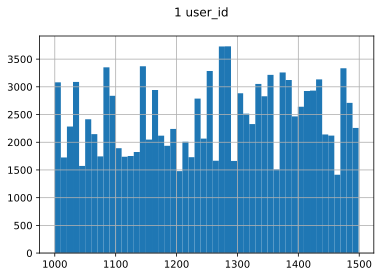

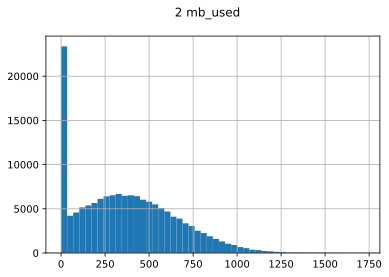

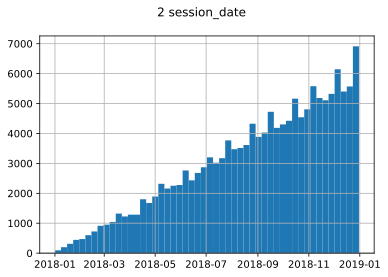

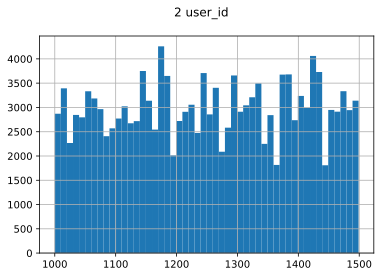

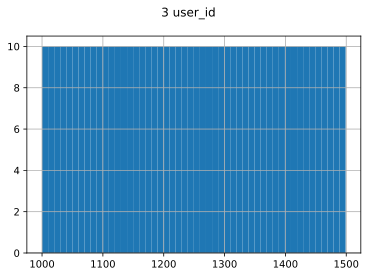

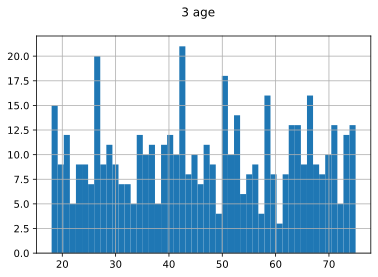

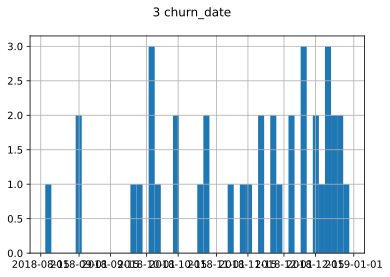

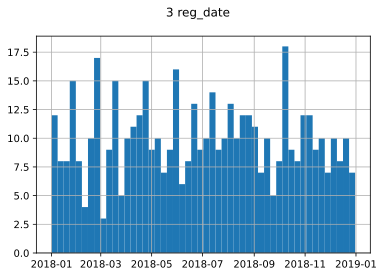

In [21]:
# проверка числовых значений на аномалии
for i, df in enumerate([calls_df, messages_df, internet_df, users_df]):
    for column in df.select_dtypes(['int', 'float', 'datetime64[ns]']).columns:
        df[column].hist(bins=50)
        plt.suptitle(str(i) + ' ' + column)
        plt.show()

Есть 2 аномалии: нулевые значения трафика в интернет-сессии и продолжительность звонка.

Нулевая продолжительность звонка объяснена в документации — это исходящие звонки, на которые не ответили.

Нулевые сессии явно не объяснены, но скорее всего это не ошибки, а техническая установка связи, при которой реального запроса не было.

При этом если исключить аномалии, распределение этих величин выглядит близко к Пуассоновскому.  

## 3. Подготовка данных
Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

In [22]:
# добавим месяц в таблицы с услугами связи
calls_df['month'] = calls_df['call_date'].dt.month
messages_df['month'] = messages_df['message_date'].dt.month
internet_df['month'] = internet_df['session_date'].dt.month

In [23]:
# построим таблицу с потреблением услуг связи каждым пользователем в каждый месяц
months_df = (calls_df.pivot_table(index=['user_id', 'month'],
                                  values='duration',
                                  aggfunc='sum')
                     .rename(columns={'duration':'calls_duration'}))

months_df = months_df.join((messages_df.pivot_table(index=['user_id', 'month'],
                                                    values='message_id',
                                                    aggfunc='count'))
                                       .rename(columns={'message_id':'messages'}),
                            how='outer')

months_df = months_df.join((internet_df.pivot_table(index=['user_id', 'month'],
                                                    values='mb_used',
                                                    aggfunc='sum'))
                                       .rename(columns={'mb_used':'gb_used'})
                                       / 1024,  # переведём mb в gb 
                            how='outer')

# округлим вверх gb_used
months_df['gb_used'] = np.ceil(months_df['gb_used'])

months_df.sample(5)

,,calls_duration,messages,gb_used
user_id,month,,,
1170,12,703.0,46.0,16.0
1061,8,639.0,12.0,22.0
1444,12,631.0,63.0,20.0
1051,9,311.0,6.0,14.0
1484,8,345.0,91.0,12.0


In [24]:
# проверка, что все данные проброшены в months_df верно
(months_df['calls_duration'].sum() == calls_df['duration'].sum(),
 months_df['messages'].sum() == messages_df['message_id'].count(),
 months_df['gb_used'].sum() == sum([np.ceil(n) for n in  \
     internet_df.groupby(by=['user_id', 'month']).sum()['mb_used'].values / 1024]))

(True, True, True)

In [25]:
months_df.sample(4)

,,calls_duration,messages,gb_used
user_id,month,,,
1352,9,743.0,10.0,17.0
1314,12,483.0,20.0,16.0
1468,7,280.0,9.0,13.0
1454,3,409.0,20.0,10.0


In [26]:
# в какие-то месяцы пользователь мог не использовать какой-то вид связи, заполним пропуски нулями
months_df.fillna(0, inplace=True)

# и приведём значения к целочисленным
months_df['messages'] = months_df['messages'].astype('int')
months_df['gb_used'] = months_df['gb_used'].astype('int')

months_df.sample(5)

,,calls_duration,messages,gb_used
user_id,month,,,
1204,9,357.0,0,19
1149,6,159.0,91,23
1436,5,370.0,29,23
1300,10,731.0,191,38
1005,7,569.0,56,8


In [27]:
# избавимся от мультииндекса
months_df.reset_index(inplace=True)
months_df.sample(5)

,user_id,month,calls_duration,messages,gb_used
2660,1414,12,397.0,46,17
953,1150,11,438.0,118,15
2804,1435,2,204.0,0,6
581,1092,9,258.0,56,24
1361,1213,10,401.0,82,17


In [28]:
# добавим информацию о тарифах в months_df
months_df = months_df.merge(users_df[['user_id', 'tariff']], how='left', on='user_id')
months_df.sample(7)

,user_id,month,calls_duration,messages,gb_used,tariff
2210,1350,10,456.0,55,24,ultra
2022,1319,9,729.0,60,21,smart
2977,1464,10,631.0,26,22,smart
1483,1232,11,234.0,27,10,smart
3073,1477,4,121.0,19,5,smart
92,1012,7,223.0,12,23,smart
3140,1486,11,764.0,96,36,smart


In [29]:
# функция расчёта стоимости услуги связи
def service_price(used, included, price_per_unit):
    return (used - included) * price_per_unit if used > included else 0

# функция расчёта выручки на клиента за месяц
def revenue_calculation(row):
    tariff = tariffs_df.query('tariff_name == @row.tariff')
    
    calls_price = service_price(row['calls_duration'],
                                tariff['minutes_included'].values[0],
                                tariff['rub_per_minute'].values[0])
    
    messages_price = service_price(row['messages'],
                                   tariff['messages_included'].values[0],
                                   tariff['rub_per_message'].values[0])
    
    internet_price = service_price(row['gb_used'],
                                   tariff['gb_included'].values[0],
                                   tariff['rub_per_gb'].values[0])
    
    return (tariff['rub_monthly_fee'].values[0]  # стоимость тарифа
            + calls_price
            + messages_price
            + internet_price)

In [30]:
# тестируем функцию для тарифа smart
revenue_calculation(pd.Series({'calls_duration': 507,
                               'messages': 53,
                               'gb_used': 17,
                               'user_id': 1092,
                               'tariff': 'smart'
                              }))

980

In [31]:
# тестируем функцию для тарифа ultra
revenue_calculation(pd.Series({'calls_duration': 3004,
                               'messages': 1006,
                               'gb_used': 31,
                               'user_id': 1495,
                               'tariff': 'ultra'
                              }))

2110

In [32]:
months_df['revenue'] = months_df.apply(revenue_calculation, axis=1)
months_df.sample(5)

,user_id,month,calls_duration,messages,gb_used,tariff,revenue
556,1089,2,5.0,27,3,ultra,1950.0
421,1066,6,184.0,14,5,smart,550.0
946,1149,9,243.0,99,25,smart,2697.0
1847,1291,10,584.0,0,12,smart,802.0
2887,1452,8,150.0,51,30,ultra,1950.0


## 4. Анализ и очистка данных

In [33]:
months_df.tariff.value_counts(normalize=True)

smart    0.693528
ultra    0.306472
Name: tariff, dtype: float64

70% наблюдений — за клиентами тарифа «Смарт».

In [34]:
values_df = months_df.pivot_table(
    index='tariff',
    values=['calls_duration', 'messages', 'gb_used', 'revenue'],
    aggfunc=['median', 'mean', 'var', 'std'])
values_df.round().astype('int').T

tariff                  smart   ultra
median calls_duration     422     518
       gb_used             17      19
       messages            28      38
       revenue           1023    1950
mean   calls_duration     418     527
       gb_used             16      19
       messages            33      49
       revenue           1290    2070
var    calls_duration   36219  100874
       gb_used             33      97
       messages           797    2285
       revenue         669786  141517
std    calls_duration     190     318
       gb_used              6      10
       messages            28      48
       revenue            818     376

Пользователям ultra в среднем нужно не сильно больше минут, смсок и интернета, чем пользователям smart

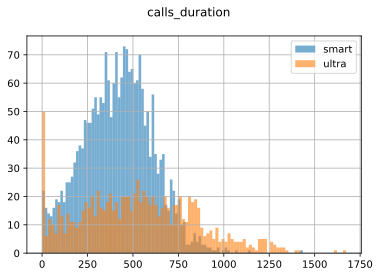

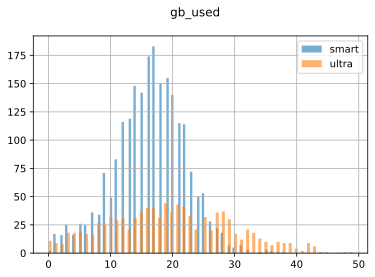

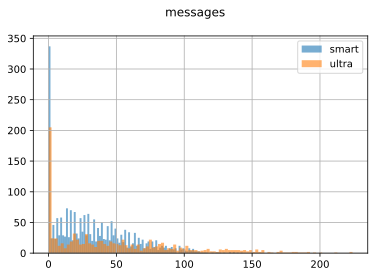

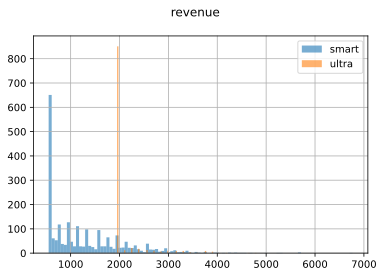

In [35]:
for column in ['calls_duration', 'gb_used', 'messages', 'revenue']:
    for tariff in ['smart', 'ultra']:
        months_df.query("tariff == @tariff")[column].hist(bins=100, alpha=0.6)
    plt.suptitle(column)
    plt.legend(['smart', 'ultra'])
    plt.show()

Если звонят и пользуются интернетом почти все, довольно заметное число пользователей совсем не использует смс.

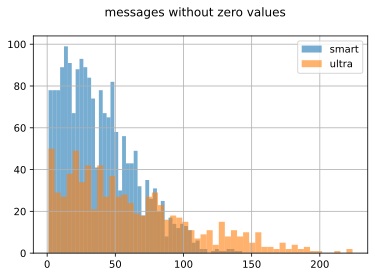

In [36]:
# посмотрим на гистограмму сообщений, если отбросить месяцы, где пользователь отправил 0 сообщений
for tariff in ['smart', 'ultra']:
    months_df.query("tariff == @tariff and messages > 0")['messages'].hist(bins=50, alpha=0.6)
plt.suptitle('messages without zero values')
plt.legend(['smart', 'ultra'])
plt.show()

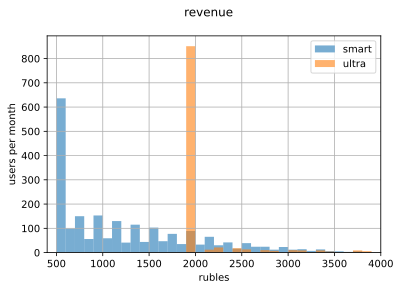

In [37]:
# посмотрим красивый график для выручки
for tariff in ['smart', 'ultra']:
    (months_df.query("tariff == @tariff")['revenue']
              .hist(bins=range (500, 4000, 100), alpha=0.6))
plt.suptitle('revenue')
plt.legend(['smart', 'ultra'])
plt.xlim(400, 4000)
plt.xlabel('rubles')
plt.ylabel('users per month')
plt.show()

Распределения величин потребления услуг (если отбросить 0 у сообщений) похожи на распредения Пуассона.

По гистограмме выручки выдно, что достаточно много людей не выходят за лимиты тарифов, особенно в тарифе Ультра.

Возможно в данных потребления услуг есть выбросы в виде больших значений, но по разнице среднего и медианы это не выглядит большой проблемой.

In [38]:
# тем не менее очистим данные от выбросов
masks_dict = {}

for column in ['calls_duration', 'messages', 'gb_used', 'revenue']:

    # рассчитываем квартили и интерквартильное расстояние 
    Q1 = months_df[column].quantile(0.25)
    Q3 = months_df[column].quantile(0.75)
    IQR = Q3 - Q1

    # строим маску по выбросам
    mask_str = column + ".outliers"
    mask = (months_df[column] < Q1 - 1.5*IQR) | (months_df[column] > Q3 + 1.5*IQR)

    # очищаем данные от выбросов
    months_df.loc[mask, column] = np.nan
    
    # добавляем маску и индексы проблемных строк во вспомогательные словари
    masks_dict[mask_str] = mask

In [39]:
# посмотрим, есть ли проблемы в данных
is_no_errors = True
for key in masks_dict.keys():
    if masks_dict[key].sum() > 0:
        print(masks_dict[key].sum(), '\t', key)
        is_no_errors = False
if is_no_errors:
    print('Data passed all checks')

63 	 calls_duration.outliers
91 	 messages.outliers
104 	 gb_used.outliers
35 	 revenue.outliers


In [40]:
months_df.shape[0]

3214

In [41]:
months_df.dropna().shape[0] / months_df.shape[0]

0.925326695706285

Выбросы есть примерно в 7% строк. При выборке около 3000 строк для нашей задачи (сравнение выборочных средних) мы без проблем можем удалить строки с выбросами из датасета.

In [42]:
months_df.dropna(inplace=True)
months_df.shape[0]

2974

## 5. Проверка гипотез
Гипотезы:
1. >Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
2. >Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### 5.1. Ультра и Смарт

За нулевую гипотезу возьмём утверждение:
>Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны

Альтернативная гипотеза:
>Cредние выручки тарифов не равны.


In [43]:
# установим достовеность 5%
alpha = 0.05

Так как мы рассматриваем не всех пользователей сравниваемых тарифов, а только части, мы имеем дело с выборками двух генеральных совокупностей. 

Как мы уже выяснили, размеры выборок не совпадают, значит нельзя считать, что у них одинаковые дисперсии, что важно указать в параметре выбранного теста.

Генеральные совокупности независимы, так как мы исследуем пользователей разных тарифов, а не, например, изменение одного тарифа на одних и тех же пользователях.

Используем t-тест на равенство средних двух выборок независимых генеральных совокупностей.

In [44]:
tariffs_test = st.ttest_ind(months_df.query("tariff == 'smart'").revenue,
                            months_df.query("tariff == 'ultra'").revenue,
                            equal_var=False)
print('p-value:', tariffs_test.pvalue)

ckeck = tariffs_test.pvalue < alpha
print("Отвергаем нулевую гипотезу") if ckeck else print("Не получилось отвергнуть нулевую гипотезу")

p-value: 1.412929e-317
Отвергаем нулевую гипотезу


То есть в мире, где средние выручки тарифов равны, наблюдаемая разница выборочных средних может получиться случайно с вероятностью 1,4 * 10^-317, что почти невозможно.

Такое p-значение, позволило бы отвергнуть нулевую гипотезу и при куда более строгих требованиях к статичтической значимости.

### 5.2. Москва и регионы

За нулевую гипотезу возьмём утверждение:

>Средняя выручка пользователей Москвы равна средней выручке в других регионах

Альтернативная гипотеза:

>Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [45]:
# проверим, нет ли дубликатов в способах написания Москвы
print(*users_df['city'].sort_values().unique(), sep='\n')

Архангельск
Астрахань
Балашиха
Барнаул
Белгород
Брянск
Владивосток
Владикавказ
Владимир
Волгоград
Волжский
Вологда
Воронеж
Грозный
Екатеринбург
Иваново
Ижевск
Иркутск
Казань
Калининград
Калуга
Кемерово
Киров
Кострома
Краснодар
Красноярск
Курган
Курск
Липецк
Магнитогорск
Махачкала
Москва
Мурманск
Набережные Челны
Нижневартовск
Нижний Новгород
Нижний Тагил
Новокузнецк
Новороссийск
Новосибирск
Омск
Оренбург
Орёл
Пенза
Пермь
Петрозаводск
Подольск
Ростов-на-Дону
Рязань
Самара
Санкт-Петербург
Саранск
Саратов
Севастополь
Смоленск
Сочи
Ставрополь
Стерлитамак
Сургут
Тамбов
Тверь
Тольятти
Томск
Тула
Тюмень
Улан-Удэ
Ульяновск
Уфа
Хабаровск
Химки
Чебоксары
Челябинск
Череповец
Чита
Якутск
Ярославль


In [46]:
# добавим информацию о городе в months_df
months_df = months_df.merge(users_df[['user_id', 'city']], how='left', on='user_id')
months_df.sample()

,user_id,month,calls_duration,messages,gb_used,tariff,revenue,city
378,1063,12,231.0,0.0,6.0,ultra,1950.0,Тула


In [47]:
# оценим размеры выборок
moscow_s = months_df.query("city == 'Москва'").revenue
regions_s = months_df.query("city != 'Москва'").revenue

moscow_s.count(), regions_s.count()

(569, 2405)

Размеры выборок в данном случае тоже значительно отличаются. То есть мы не можем предполагать равенство дисперсий.

Это выборки независимых генеральных совокупностей, так как мы рассматриваем пользователей из разных городов, один раз выбравших и не менявших тариф.

Используем t-тест на равенство средних двух выборок независимых генеральных совокупностей.

In [48]:
moscow_test = st.ttest_ind(moscow_s, regions_s, equal_var=False)
print('p-value:', moscow_test.pvalue)
print("Отвергаем нулевую гипотезу") if moscow_test.pvalue < alpha else print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.2818595914383352
Не получилось отвергнуть нулевую гипотезу


В мире, где нулевая гипотеза верна, то есть средняя выручка по Москве и в регионах равны, есть вероятность чуть больше 28%, что такая разница между выборочными средними получилась случайно. Это довльно большой показатель для выбранной статзначимости. 

То есть у нас нет причин считать, что по данным тарифам получается значительно различная средняя выручка. 

In [49]:
# кстати, посмотрим, какая
moscow_s.mean(), regions_s.mean()

(1464.7715289982425, 1430.1945945945945)

И правда, разница не очень большая.

## 6. Выводы

Значительных проблем в данных не выялено. 

В таблице дохода и детализации по способам связи есть выбросы, около 7% cтрок из более чем 3000. Данные перед оценкой гипотез были очищены от выбросов.

Основные параметры тарифов по месяцам на одного клиента:

In [50]:
values_df.round().astype('int').T

tariff                  smart   ultra
median calls_duration     422     518
       gb_used             17      19
       messages            28      38
       revenue           1023    1950
mean   calls_duration     418     527
       gb_used             16      19
       messages            33      49
       revenue           1290    2070
var    calls_duration   36219  100874
       gb_used             33      97
       messages           797    2285
       revenue         669786  141517
std    calls_duration     190     318
       gb_used              6      10
       messages            28      48
       revenue            818     376

Мы проверили 2 гипотезы.
1. >✅ Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Со статзначимостью 5% мы отвергли нулевую гипотезу, что средние тарифов равны.
Больше того, при условии, средние генеральных совокупностей были бы равны, вероятноность случайно собрать выборки с таким отличием средних равна 1,4 * 10^-317.

Выборочные средние выручки (в месяц на пользователя) по тарифам заметно различаются:

In [51]:
values_df[('mean', 'revenue')].round().astype('int').to_frame()

,mean
,revenue
tariff,
smart,1290
ultra,2070


Тариф Ультра — более выгодный с точки зрения доходности.

Стоит приннять во внимание, что на этом тарифе используют в среднем больше услуг связи.

In [52]:
x = ['calls_duration', 'messages', 'gb_used']
y = [values_df[('mean', column)]['ultra'] / values_df[('mean', column)]['smart']   \
     for column in x]

communication_services_usage = pd.DataFrame(index=x,
                                            data=y,
                                            columns=['ultra_in_perc_of_smart'])
communication_services_usage

,ultra_in_perc_of_smart
calls_duration,1.260061
messages,1.478655
gb_used,1.193864


Если затраты на их обслуживание не превысят разницу в прибыли, а также отсутствуют риски критического ухудщения качества услуг от роста объёма их использования, стоит продвигать этот тариф, мотивируя новых пользователей выбирать Ультру, а существующих пользователей Смарта — переходить на Ультру. 

___


2. >🤷‍♂️ Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевую гипотезу о равенстве средних не удалось отвергнуть со статзначимостью 5% (p-value ≈ 28%).
То есть в мире, где средние равны, вероятность случайно взять выборки, где средние будут отличаться как в нашем случае, равна 28%. То есть у нас нет оснований считать, что средние значимо различаются. 

Средние выручки не очень отличаются:

In [72]:
pd.Series({'Москва': moscow_s.mean(),
           'Регионы': regions_s.mean()}
    ).round().astype('int').to_frame()

,0
Москва,1465
Регионы,1430


У нас нет повода считать, что выручка в месяц с москвича значительно отличается от выручки с жителя другого населённого пункта.